In [1]:
# Importing Libraries
import os
import shutil
import random
!pip install split-folders
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Define Paths for Bishop Project
dataset_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision"
input_folder_binary = "/content/gdrive/My Drive/Datasets/Chess_Vision_Binary_Bishop_Input"
output_folder = "/content/gdrive/My Drive/Datasets/Chess_Vision_Binary_Bishop"

In [3]:
# Function to Copy Files (reuse existing function)
def copy_files(src, dst):
    os.makedirs(dst, exist_ok=True)
    for file in os.listdir(src):
        shutil.copy(os.path.join(src, file), dst)

# Prepare Dataset for Bishop
non_bishop_dir = os.path.join(dataset_dir, "Non_Bishop")
if not os.path.exists(non_bishop_dir):
    os.makedirs(non_bishop_dir)

other_pieces = ["Rook", "Knight", "Queen", "King", "Pawn"]
num_images_per_class = 23

# Copy images for Non_Bishop class
if len(os.listdir(non_bishop_dir)) < 110:
    for piece in other_pieces:
        piece_dir = os.path.join(dataset_dir, piece)
        images = random.sample(os.listdir(piece_dir), num_images_per_class)
        for img in images:
            shutil.copy(os.path.join(piece_dir, img), os.path.join(non_bishop_dir, f"{piece}_{img}"))

In [4]:
# Count Images for Bishop
bishop_count = len(os.listdir(os.path.join(dataset_dir, "Bishop")))
non_bishop_count = len(os.listdir(non_bishop_dir))
print(f"Number of Bishop images: {bishop_count}")
print(f"Number of Non_Bishop images: {non_bishop_count}")

Number of Bishop images: 87
Number of Non_Bishop images: 115


In [6]:
# Prepare Input Directory for Binary Classification
os.makedirs(input_folder_binary, exist_ok=True)
copy_files(os.path.join(dataset_dir, "Bishop"), os.path.join(input_folder_binary, "Bishop"))
copy_files(non_bishop_dir, os.path.join(input_folder_binary, "Non_Bishop"))

# Split Dataset
splitfolders.ratio(input_folder_binary, output=output_folder, seed=42, ratio=(.7, .2, .1))

Copying files: 202 files [00:02, 82.67 files/s]


In [7]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test sets

# Load images from directory and apply transformations
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)


Found 138 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [8]:
# Load VGG16 model without the top layer
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

# Define the input layer
inputs = Input(shape=(224, 224, 3))

# Pass the image through the base model
x = base_model(inputs, training=False)

# Flatten the output of the base model
x = Flatten()(x)

# Additional layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)  # Updated dropout rate

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
binary_model = Model(inputs, outputs)

# Compile the model
binary_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Updated learning rate
                     metrics=["accuracy"])


58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# Callbacks (modify for Bishop model saving)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Datasets/bishop_detector_best_model.h5', save_best_only=True,
                                   monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [10]:
epochs = 10
batch_size = 32

history = binary_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[model_checkpoint, reduce_lr, early_stopping]
)


Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.7723 - accuracy: 0.5580 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 121s 24s/step - loss: 0.7723 - accuracy: 0.5580 - val_loss: 0.6731 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 132s 31s/step - loss: 0.6508 - accuracy: 0.6449 - val_loss: 0.6618 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 3/10
5/5 [==============================] - 137s 29s/step - loss: 0.6125 - accuracy: 0.6739 - val_loss: 0.6063 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 4/10
5/5 [==============================] - 138s 29s/step - loss: 0.6063 - accuracy: 0.6884 - val_loss: 0.5728 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 5/10
5/5 [==============================] - 131s 31s/step - loss: 0.4566 - accuracy: 0.7971 - val_loss: 0.6044 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 6/10
5/5 [==============================] - 130s 27s/step - loss: 0.4989 - accuracy: 0.7174 - val_loss: 0.5512 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 7/10
5/5 [==============================] - 140s 33s/step - los

1/1 [==============================] - 14s 14s/step - loss: 0.3892 - accuracy: 0.8500
Test Accuracy: 85.00%
1/1 [==============================] - 13s 13s/step
              precision    recall  f1-score   support

  Non_Bishop       0.89      0.80      0.84        10
      Bishop       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



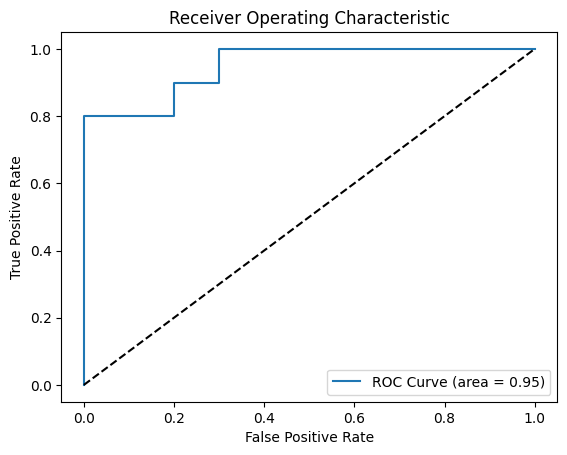

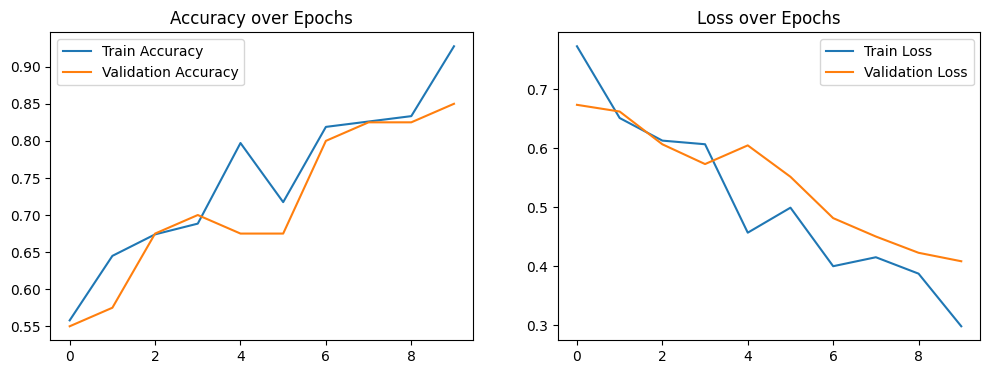

In [11]:
# Evaluate the Model
test_loss, test_accuracy = binary_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate Predictions and Evaluate
probabilities = binary_model.predict(test_generator)
predictions = [1 if x > 0.5 else 0 for x in probabilities.ravel()]
true_classes = test_generator.classes
report = classification_report(true_classes, predictions, target_names=['Non_Bishop', 'Bishop'])
print(report)

# ROC-AUC Score and Curve
roc_auc = roc_auc_score(true_classes, probabilities)
fpr, tpr, thresholds = roc_curve(true_classes, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()